# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.stats as stats

In [2]:
df = pd.read_csv('data/human_body_temperature.csv')
%matplotlib inline

## Question 1

While the data would most rationally have the central limit theorem apply by virtue of having finite mean and variance, it still serves good to check the assumptions. We have reason to believe that the distribution is normally distributed, and to check this, we use a q-q plot against a standard normal distribution.

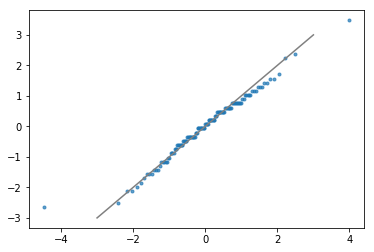

In [3]:
temp = df.temperature
temp_zscore = np.sort((temp - temp.mean())/temp.std())
normal_scale = np.random.normal(0,1,10000)
percentiles = np.percentile(normal_scale, np.linspace(0,100,len(temp_zscore)))

plt.plot(percentiles, temp_zscore, ls="", marker=".", alpha=0.7)
plt.plot([-3, 3], [-3, 3], ls="-", marker="", color="grey")

From the output of the q-q plot, it seems to agree fairly well because it lies on a straight line against a standard normal distribution, at least in the center portion of the distribution. The top tail is thinner than the normal distribution, with the exception of the far outlier in both directions. Overall, this is probably close enough to normal for the z- and t- tests because they are rather robust.

We can further test this by using a test of normality, such as an Anderson–Darling Test. With the number of data points we have, we would need to see an adjusted A-squared statistic greater than 0.754 to reject the null hypothesis of normally distributed at the p = 0.05 level of significance. 

In [4]:
def phi(x):
    # Cumulative distribution function for the standard normal distribution
    return (1 + math.erf(x / math.sqrt(2))) / 2

In [5]:
a_sq_sum = 0
n = len(temp_zscore)
for i in range(n):
    a_sq_sum += (2*(i+1)-1) * math.log(phi(temp_zscore[i]))+(2*(n-(i+1))+1)*math.log(1-phi(temp_zscore[i]))
a_sq_adj = (-n - 1/n * a_sq_sum) * (1 + 4/n - (5/n) ** 2)
a_sq_adj

0.5353376946195331

Since the test statistic does not meet our rejection threshold (0.754), we fail to reject the null hypothesis, so we can proceed assuming that the distribution is well-approximated by the normal distribution. 

## Question 2

A sample size of 130 is generally considered large enough to be able to use a z-test approximation for the normal distribution with the Central Limit Theorem. We can only hope that the data has been collected in a manner which is statistically independent, such as selecting the sample in a way to minimize biases, since there isn't a good way to test for this within the data. 

## Question 3

To test this, we can approach this in a number of ways. We can do a simulation or frequentist methods to answer the question. 

### Bootstrap Simulation

In [6]:
def draw_bs_replica(data, func, size=1):
    # This function draws the replicates
    replicates = np.empty(size)
    for i in range(size):
        replicates[i] = func(np.random.choice(data, size=len(data)))
    return replicates

We first need to figure out how extreme the observed value is from our hypothesized mean, 98.6:

In [7]:
diff = 98.6 - temp.mean()
diff

0.35076923076921673

Then, we do a two-sided bootstrap test and check the number of samples returned a more extreme value than the one we observed:

In [8]:
np.random.seed(3)
replicates = draw_bs_replica(temp, np.mean, 10000)
p = np.sum(np.logical_or(-diff >= 98.6 - replicates, 98.6 - replicates >= diff)) / len(replicates)
p

0.4919

Since a value in the 0.4-0.5 range is not a significant p-value, we fail to find any evidence to reject the null hypothesis of that the true population mean is 98.6 by the bootstrap method. 

### Frequentist Analysis

We see that there is one sample because we are concerned with our temperature matches a "known value". Our sample size should be large enough to just use a z-test, but for completeness, a z-test and a t-test will be conducted.

In [9]:
z_stat = (temp.mean() - 98.6)/(temp.std() / math.sqrt(len(temp)))
z_stat

-5.454823292364079

This z-statistic is so far outside the normal range that even without looking at a z-table one can easily reject the null hypothesis. That is, the data contains enough evidence that the true mean is not 98.6 degrees F. This would be true regardless of if the z-test or the t-test were taken; that is how extreme this statistic is. 

## Question 4

To investigate the effect of the sample size on the test statistics, we first will be drawing from a sample of the data we do have. 

In [10]:
np.random.seed(4)
sample = np.random.choice(temp, 10)

Then, we take the z-statistic of our new sample:

In [11]:
z_stat_samp = (sample.mean() - 98.6)/(sample.std() / math.sqrt(len(sample)))
z_stat_samp

-1.2309149097933223

We can calculate the corresonding one-sided p-value by applying phi(x):

In [12]:
z_pval = phi(z_stat_samp)
z_pval

0.10917734528295181

And the correspoding one-sided one-sample t-test uses the following:

In [13]:
t_pval = stats.t.cdf(x=z_stat_samp, df=9)
t_pval

0.1247760127206702

We can see that the p-value is larger, representing the thicker tails of the t-distribution compared to a standard Gaussian distribution. However, since the z-test already is not significant at even the 10% level, the t-test shows that it is even more so.

## Question 5

To answer this question, we can construct a prediction interval with approximately $\alpha=0.05$. Then, we can deem observations outside our prediction interval to be unlikely. We shall do this in the bootstrap method and in the frequentist method. 

First, we note the fact that order statistics $[X_{(i)}, X_{(j)}]$ forms a prediction interval with  $\alpha = 1 - \frac{n+1-2i}{n+1}$ provided that $i < j, i+j-1 = n$. For our sample size of 130, this means we need to take the 3rd order statistic and the 128th order statistic for the closest value of alpha being 0.0458 (exact value $\frac{6}{131}$).

In [25]:
(np.sort(temp)[2], np.sort(temp)[-3])

(96.7, 99.9)

We then refine this a bit more by adding bootstrapping:

In [35]:
np.random.seed(5)
lower_b = draw_bs_replica(temp, lambda x: np.sort(x)[2], 10000)
upper_b = draw_bs_replica(temp, lambda x: np.sort(x)[-3], 10000)
(lower_b.mean(), upper_b.mean())

(96.64229000000002, 99.79866)

For the frequentist approach, we construct a prediction interval using the t-distribution using the following distribution:

In [34]:
%%latex 
\begin{equation}
\frac{X_{n+1} - \bar{X}_n}{s_n \sqrt{1+1/n}} \sim T_{n-1}
\end{equation}

<IPython.core.display.Latex object>

To be comparable with our non-parametric method above, we will set our alpha to match as well. 

In [38]:
margin = temp.std()*math.sqrt(1+1/len(temp))*stats.t.ppf(1-3/131, 129)
(temp.mean() - margin, temp.mean() + margin)

(96.76493540616197, 99.73352613229959)

We can see that both methods agree that a temperature above about 99.75 is considered abnormally high, while a temperature below about 96.7 is considered abnormally low.

## Question 6

This question asks us to compare the means of two populations. We can do this via bootstrapping or by doing an unpaired two-sample t-test.

In [57]:
temp_m = temp[df.gender == "M"]
temp_f = temp[df.gender == "F"]
gender_mean_diff = np.mean(temp_m) - np.mean(temp_f)
gender_mean_diff

-0.289230769230727

In [61]:
def draw_bs_replica_paired(data, func, n, size=1):
    # This function draws the replicates
    replicates_a = np.empty(size)
    replicates_b = np.empty(size)
    for i in range(size):
        replicates = np.random.choice(data, size=len(data))
        replicates_a[i] = func(replicates[:n])
        replicates_b[i] = func(replicates[n:])
    return replicates_a, replicates_b
np.random.seed(6)
paired_rep_M, paired_rep_F = draw_bs_replica_paired(temp, np.mean, len(temp_m), 10000)
gender_diff_bootstrap = paired_rep_M - paired_rep_F
p_bootstrap = sum(gender_diff_bootstrap <= gender_mean_diff) / len(gender_diff_bootstrap)
p_bootstrap

0.0108

We see from the above that our bootstrap test states that only about 1% of the replicates showed as or more extreme of a value as the real difference. Next, we do Welch's t-test to verify this result. 

In [68]:
se = np.sqrt(np.var(temp_m, ddof=1)/len(temp_m) + np.var(temp_f, ddof=1)/len(temp_f))
nu = (np.var(temp_m, ddof=1)/len(temp_m) + np.var(temp_f, ddof=1)/len(temp_f)) ** 2 / (np.var(temp_m, ddof=1)**2/((len(temp_m)-1)*len(temp_m)**2) + (np.var(temp_f, ddof=1)**2/((len(temp_f)-1)*len(temp_f)**2)))
t = gender_mean_diff / se 
p_welch = stats.t.cdf(x=t, df=nu)
p_welch

0.011969132091477257

Since Welch's t-test also shows a p-value in the 1% range, we can say that at the alpha = 0.05 level, there is evidence that the mean temperature between male and female subjects are different. 